In [1]:
% matplotlib inline

import numpy as np
import torch

import tqdm

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

from utils import sqrtm, bures, MI_dist, MK_dist, KR_dist, subspace_gd

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

## Noise

Signal supported on k directions out of d

In [3]:
A = np.array([[2., 0.3, -0.1, 0.3],
             [0.3, 0.5, -0.3, -0.2],
             [-0.1, -0.3, 1, 0.5],
             [0.3, -0.2, 0.5, 1.5]])

B = np.array([[.5, -0.5, 0.1, -0.2],
             [-0.5, 2, 0.3, 0.4],
             [0.1, 0.3, 1, -0.5],
             [-0.2, 0.4, -0.5, 1.]])

In [4]:
print(A)

[[ 2.   0.3 -0.1  0.3]
 [ 0.3  0.5 -0.3 -0.2]
 [-0.1 -0.3  1.   0.5]
 [ 0.3 -0.2  0.5  1.5]]


In [5]:
print(B)

[[ 0.5 -0.5  0.1 -0.2]
 [-0.5  2.   0.3  0.4]
 [ 0.1  0.3  1.  -0.5]
 [-0.2  0.4 -0.5  1. ]]


### k = 4, d = 8

In [6]:
r = 4
d = A.shape[0]

n = 100

errs = np.array([1e-3, 1e-2, 1e-1, 2e-1])
#errs = np.array([1e-2, 1e-1, 2e-1])


nerrs = len(errs)

A /= np.linalg.norm(A)
B /= np.linalg.norm(B)

K = np.arange(1, d+r+1)

mks = np.zeros((n, nerrs, d+r))
mis = np.zeros((n, nerrs, d+r))

min_mks = np.zeros((n, nerrs, d+r))

bs = np.zeros((n, nerrs))
krs = np.zeros((n, nerrs))

all_losses = [[]]

for i in tqdm.tqdm(range(n)):

    A_zero = np.zeros((d + r, d + r))
    B_zero = np.zeros((d + r, d + r))

    L1 = np.random.randn(d + r, d + r)
    L2 = np.random.randn(d + r, d + r)

    A_zero[:d, :d] = A
    B_zero[:d, :d] = B

    for j, eps in enumerate(errs):

        A_noisy = A_zero + eps * L1.dot(L1.T) / (d+r)
        B_noisy = B_zero + eps * L2.dot(L2.T) / (d+r)

        krs[i, j] = KR_dist(A_noisy, B_noisy)
        bs[i, j] = bures(A_noisy, B_noisy)

        for k in K:
            mis[i, j, k-1] = MI_dist(A_noisy, B_noisy, k)
            mks[i, j, k-1] = MK_dist(A_noisy, B_noisy, k)
            
            if k < d + r:
                _, losses = subspace_gd(torch.from_numpy(A_noisy), torch.from_numpy(B_noisy), niter=100, k = k, lr= 5e-4, verbose=False)
                min_mks[i, j, k-1] = np.min(losses)
                all_losses.append(losses)
            else:
                min_mks[i, j, k-1] = mks[i, j, k-1]
            

100%|██████████| 100/100 [07:47<00:00,  4.78s/it]


In [8]:
colors = ['blue', 'orange', 'red', 'green']

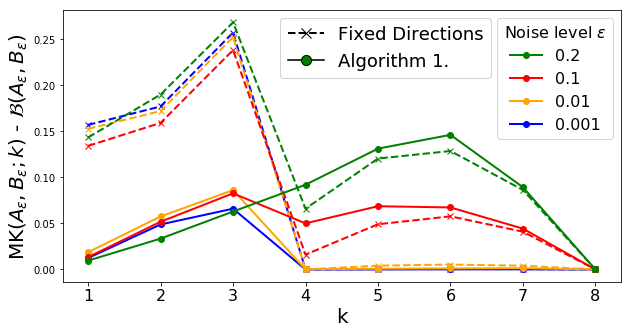

In [9]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))


K = np.arange(1, 9)

for j in range(nerrs):
    
    ax.plot(K, (mks - bs[:, :, None]).mean(axis=0)[j], marker='x', linestyle = '--', color = colors[j], lw = 2)
    #ax.fill_between(K, np.quantile(mks - bs[:, :, None], 0.1, axis=0)[j], np.quantile(mks - bs[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    #ax.fill_between(K, np.quantile(mks - bs[:, :, None], 0.25, axis=0)[j], np.quantile(mks - bs[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])
    
    ax.plot(K, (min_mks - bs[:, :, None]).mean(axis=0)[j], marker='o', label = ('%.3f' % errs[j]).rstrip('0'),  color = colors[j], lw = 2)
    #ax.fill_between(K, np.quantile(min_mks - bs[:, :, None], 0.1, axis=0)[j], np.quantile(min_mks - bs[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    #ax.fill_between(K, np.quantile(min_mks - bs[:, :, None], 0.25, axis=0)[j], np.quantile(min_mks - bs[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])


legend_elements = [Line2D([0], [0], color='black', linestyle = '--', marker='x', lw=2, label='Fixed Directions', markersize=10),
               Line2D([0], [0], marker='o', color='black', label='Algorithm 1.',
                      markerfacecolor='g', markersize=10,)]
    
    
ax.set_xlabel('k', fontsize = 20)
ax.set_ylabel(r'MK$(A_\varepsilon, B_\varepsilon ; k)$ - $\mathcal{B}(A_\varepsilon, B_\varepsilon)$', fontsize = 20)


handles,labels = ax.get_legend_handles_labels()

handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]

leg1 = ax.legend(handles, labels, loc=0, fontsize=16, title=r'Noise level $\varepsilon$',)
leg1.get_title().set_fontsize(16)

plt.legend()
#plt.title('MK: Fixed Directions vs PGD, d1=4, d2=8', fontsize=20)

leg2 = ax.legend(handles=legend_elements, bbox_to_anchor=(0.39, 0.97), loc=0, borderaxespad=0., fontsize=18)
ax.add_artist(leg2)
ax.add_artist(leg1)

plt.xticks(fontsize=16)


plt.show()

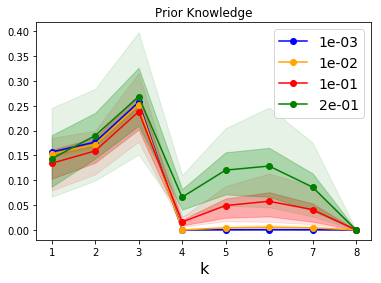

In [10]:
f, ax = plt.subplots(1, 1)


for j in range(nerrs):
    
    ax.plot(K, (mks - bs[:, :, None]).mean(axis=0)[j], marker='o', label = '%.0e' % errs[j],  color = colors[j])
    ax.fill_between(K, np.quantile(mks - bs[:, :, None], 0.1, axis=0)[j], np.quantile(mks - bs[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    ax.fill_between(K, np.quantile(mks - bs[:, :, None], 0.25, axis=0)[j], np.quantile(mks - bs[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])

ax.set_xlabel('k', fontsize = 16)
ax.legend(fontsize = 14)

plt.title('Prior Knowledge')


plt.show()

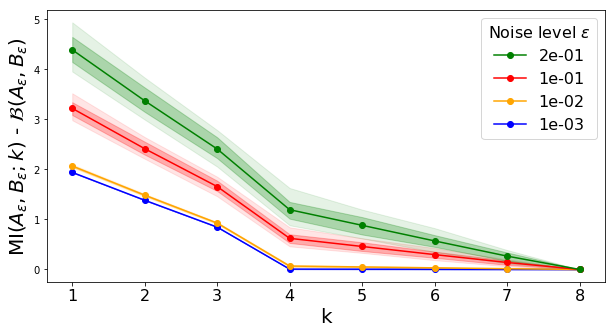

In [12]:
f, ax = plt.subplots(1, 1, figsize = (10, 5))


K = np.arange(1, 9)



for j in range(nerrs):
    
    ax.plot(K, (mis - bs[:, :, None]).mean(axis=0)[j], marker='o', label = '%.0e' % errs[j], color = colors[j])

    ax.fill_between(K, np.quantile(mis - bs[:, :, None], 0.1, axis=0)[j], np.quantile(mis - bs[:, :, None], 0.9, axis=0)[j], alpha = 0.1, color = colors[j])
    ax.fill_between(K, np.quantile(mis - bs[:, :, None], 0.25, axis=0)[j], np.quantile(mis - bs[:, :, None], 0.75, axis=0)[j], alpha = 0.25, color = colors[j])

    
handles,labels = ax.get_legend_handles_labels()

handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]

ax.set_ylabel(r'MI$(A_\varepsilon, B_\varepsilon ; k)$ - $\mathcal{B}(A_\varepsilon, B_\varepsilon)$', fontsize = 20)

leg1 = ax.legend(handles, labels, loc=0, fontsize=16, title=r'Noise level $\varepsilon$',)
leg1.get_title().set_fontsize(16)

ax.set_xlabel('k', fontsize = 20)

plt.xticks(fontsize=16)



plt.show()

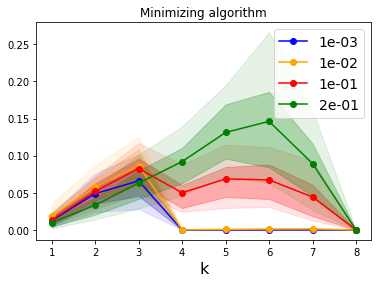

In [13]:
f, ax = plt.subplots(1, 1)


for j in range(nerrs):
    
    ax.plot(K, (min_mks - bs[:, :, None]).mean(axis=0)[j], marker='o', label = '%.0e' % errs[j],  color = colors[j])
    ax.fill_between(K, np.quantile(min_mks - bs[:, :, None], 0.1, axis=0)[j], np.quantile(min_mks - bs[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    ax.fill_between(K, np.quantile(min_mks - bs[:, :, None], 0.25, axis=0)[j], np.quantile(min_mks - bs[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])

ax.set_xlabel('k', fontsize = 16)
ax.legend(fontsize = 14)

plt.title('Minimizing algorithm')


plt.show()

(array([0.001, 0.01 , 0.1  , 0.2  ]), <a list of 4 Text xticklabel objects>)

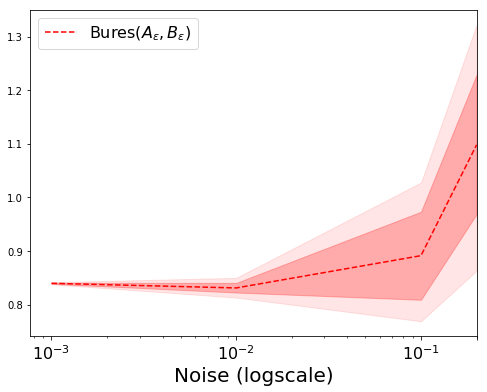

In [14]:
f, ax = plt.subplots(1, 1 , figsize = (8, 6))
  
ax.plot(errs, bs.mean(axis = 0), linestyle = '--', color = 'red', label = r'Bures$(A_\varepsilon, B_\varepsilon)$')
ax.fill_between(errs, np.quantile(bs, 0.1, axis = 0), np.quantile(bs, 0.9, axis = 0), color = 'red', alpha = 0.1)
ax.fill_between(errs, np.quantile(bs, 0.25, axis = 0), np.quantile(bs, 0.75, axis = 0), color = 'red', alpha = 0.25)

ax.set_xscale('log')

ax.set_xlim(right = max(errs))
ax.set_xticks(errs)


ax.set_xlabel('Noise (logscale)', fontsize = 20)

plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=16)


### k = 4, d = 16

In [15]:
r = 12
d = A.shape[0]
eps = 5e-1

n = 100

errs = np.array([1e-3, 1e-2, 1e-1, 2e-1])
nerrs = len(errs)

A /= np.linalg.norm(A)
B /= np.linalg.norm(B)

K = np.arange(1, d+r+1)

mks_16 = np.zeros((n, nerrs, d+r))
min_mks_16 = np.zeros((n, nerrs, d+r))


mis_16 = np.zeros((n, nerrs, d+r))
bs_16 = np.zeros((n, nerrs))
krs_16 = np.zeros((n, nerrs))

for i in tqdm.tqdm(range(n)):

    A_zero = np.zeros((d + r, d + r))
    B_zero = np.zeros((d + r, d + r))

    L1 = np.random.randn(d + r, d + r)
    L2 = np.random.randn(d + r, d + r)

    A_zero[:d, :d] = A
    B_zero[:d, :d] = B

    for j, eps in enumerate(errs):

        A_noisy = A_zero + eps * L1.dot(L1.T) / (d+r)
        B_noisy = B_zero + eps * L2.dot(L2.T) / (d+r)

        krs_16[i, j] = KR_dist(A_noisy, B_noisy)
        bs_16[i, j] = bures(A_noisy, B_noisy)


        for k in K:
            mis_16[i, j, k-1] = MI_dist(A_noisy, B_noisy, k)
            mks_16[i, j, k-1] = MK_dist(A_noisy, B_noisy, k)
            
            if k < d + r:
                _, losses = subspace_gd(torch.from_numpy(A_noisy), torch.from_numpy(B_noisy), niter=100, k = k, lr= 5e-4, verbose=False)
                #print(loss)
                #vecs, loss = SRW(torch.from_numpy(A_noisy), torch.from_numpy(B_noisy), k, lr=1e-2, verbose=False)
                #min_mks[i, j, k-1] = MK_dist(vecs.T.dot(A_noisy).dot(vecs), vecs.T.dot(B_noisy).dot(vecs), k)
                min_mks_16[i, j, k-1] = np.min(losses)
                all_losses.append(losses)
            else:
                min_mks_16[i, j, k-1] = mks_16[i, j, k-1]

100%|██████████| 100/100 [17:43<00:00, 11.34s/it]


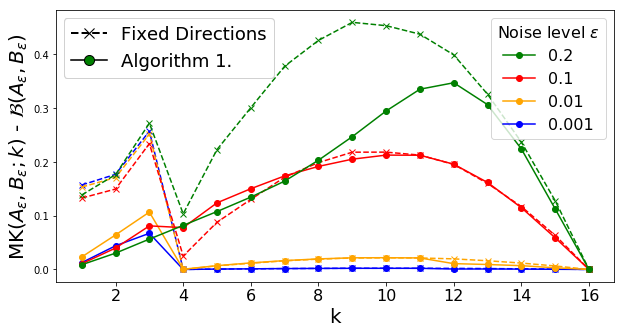

In [17]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))


K = np.arange(1, 17)

for j in range(nerrs):
    
    ax.plot(K, (mks_16 - bs_16[:, :, None]).mean(axis=0)[j], marker='x', linestyle = '--',  color = colors[j])
    #ax.fill_between(K, np.quantile(mks_16 - bs_16[:, :, None], 0.1, axis=0)[j], np.quantile(mks_16 - bs_16[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    #ax.fill_between(K, np.quantile(mks_16 - bs_16[:, :, None], 0.25, axis=0)[j], np.quantile(mks_16 - bs_16[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])
    
    ax.plot(K, (min_mks_16 - bs_16[:, :, None]).mean(axis=0)[j], marker='o', label = ('%.3f' % errs[j]).rstrip('0'),  color = colors[j])
    #ax.fill_between(K, np.quantile(min_mks_16 - bs_16[:, :, None], 0.1, axis=0)[j], np.quantile(min_mks_16 - bs_16[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    #ax.fill_between(K, np.quantile(min_mks_16 - bs_16[:, :, None], 0.25, axis=0)[j], np.quantile(min_mks_16 - bs_16[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])

ax.set_xlabel('k', fontsize = 20)
ax.set_ylabel(r'MK$(A_\varepsilon, B_\varepsilon ; k)$ - $\mathcal{B}(A_\varepsilon, B_\varepsilon)$', fontsize = 20)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]

leg1 = ax.legend(handles, labels, loc=0, fontsize=16, title=r'Noise level $\varepsilon$',)

leg1.get_title().set_fontsize(16)

plt.legend()

leg2 = ax.legend(handles=legend_elements, bbox_to_anchor=(0.39, 0.97), loc=1, borderaxespad=0., fontsize=18)
ax.add_artist(leg2)
ax.add_artist(leg1)

plt.xticks(fontsize=16)



plt.show()

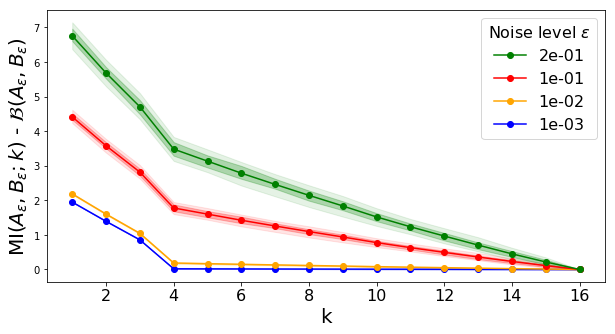

In [18]:
f, ax = plt.subplots(1, 1, figsize = (10, 5))

K = np.arange(1, 17)



for j in range(nerrs):
    
    ax.plot(K, (mis_16 - bs_16[:, :, None]).mean(axis=0)[j], marker='o', label = '%.0e' % errs[j], color = colors[j])

    ax.fill_between(K, np.quantile(mis_16 - bs_16[:, :, None], 0.1, axis=0)[j], np.quantile(mis_16 - bs_16[:, :, None], 0.9, axis=0)[j], alpha = 0.1, color = colors[j])
    ax.fill_between(K, np.quantile(mis_16 - bs_16[:, :, None], 0.25, axis=0)[j], np.quantile(mis_16 - bs_16[:, :, None], 0.75, axis=0)[j], alpha = 0.25, color = colors[j])

    
handles,labels = ax.get_legend_handles_labels()

handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]

ax.set_ylabel(r'MI$(A_\varepsilon, B_\varepsilon ; k)$ - $\mathcal{B}(A_\varepsilon, B_\varepsilon)$', fontsize = 20)


leg1 = ax.legend(handles, labels, loc=0, fontsize=16, title=r'Noise level $\varepsilon$',)

leg1.get_title().set_fontsize(16)
ax.set_xlabel('k', fontsize = 20)

plt.xticks(fontsize=16)


plt.show()

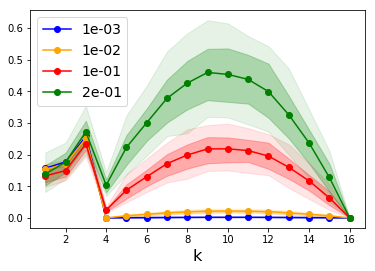

In [19]:
f, ax = plt.subplots(1, 1)


for j in range(nerrs):
    
    ax.plot(K, (mks_16 - bs_16[:, :, None]).mean(axis=0)[j], marker='o', label = '%.0e' % errs[j],  color = colors[j])
    ax.fill_between(K, np.quantile(mks_16 - bs_16[:, :, None], 0.1, axis=0)[j], np.quantile(mks_16 - bs_16[:, :, None], 0.9, axis=0)[j], alpha = 0.1,  color = colors[j])
    ax.fill_between(K, np.quantile(mks_16 - bs_16[:, :, None], 0.25, axis=0)[j], np.quantile(mks_16 - bs_16[:, :, None], 0.75, axis=0)[j], alpha = 0.25,  color = colors[j])

ax.set_xlabel('k', fontsize = 16)
ax.legend(fontsize = 14)

plt.show()

(array([0.001, 0.01 , 0.1  , 0.2  ]), <a list of 4 Text xticklabel objects>)

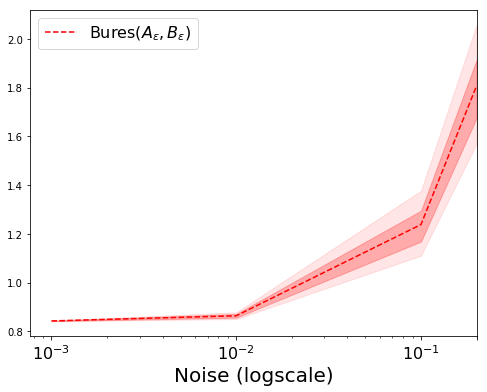

In [20]:
f, ax = plt.subplots(1, 1, figsize = (8, 6))
  
#ax.plot(np.log10(errs), bs_16.mean(axis = 0), linestyle = '--', color = 'red', label = r'Bures$(A_\varepsilon, B_\varepsilon)$')
#ax.fill_between(np.log10(errs), np.quantile(bs_16, 0.1, axis = 0), np.quantile(bs_16, 0.9, axis = 0), color = 'red', alpha = 0.1)
#ax.fill_between(np.log10(errs), np.quantile(bs_16, 0.25, axis = 0), np.quantile(bs_16, 0.75, axis = 0), color = 'red', alpha = 0.25)

ax.plot(errs, bs_16.mean(axis = 0), linestyle = '--', color = 'red', label = r'Bures$(A_\varepsilon, B_\varepsilon)$')
ax.fill_between(errs, np.quantile(bs_16, 0.1, axis = 0), np.quantile(bs_16, 0.9, axis = 0), color = 'red', alpha = 0.1)
ax.fill_between(errs, np.quantile(bs_16, 0.25, axis = 0), np.quantile(bs_16, 0.75, axis = 0), color = 'red', alpha = 0.25)



ax.set_xscale('log')

ax.set_xlim(right = max(errs))
ax.set_xticks(errs)


ax.set_xlabel('Noise (logscale)', fontsize = 20)

plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=16)

plt.show()